<a href="https://colab.research.google.com/github/Bane-24/Crypto-Price-Prediction/blob/main/Month_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Installing the required libraries
!pip install cryptocmd
!pip install yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cryptocmd import CmcScraper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import yfinance as yf
import tensorflow as tf
from tensorflow import keras

!pip install keras-tuner
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from kerastuner.tuners import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# Scrape cryptocurrency data
scraper = CmcScraper("BTC", "01-01-2014", "31-03-2023")
bitcoin_df = scraper.get_dataframe()

# Scrape stock market data
stock_data = yf.download("SPY", start="2014-01-01", end="2023-03-31")
stock_df = stock_data["Adj Close"].to_frame().reset_index().rename(columns={"Adj Close": "stock_price", "Date": "Date"})

# Create a date range that includes all dates between start and end dates
date_range = pd.date_range(start="2014-01-01", end="2023-03-31")
date_range_df = pd.DataFrame(date_range, columns=["Date"])

# Merge stock_df with the date_range_df
stock_df = stock_df.merge(date_range_df, on="Date", how="outer")
stock_df.sort_values("Date", inplace=True)


# Fill missing values using ffill and bfill methods
stock_df["stock_price"].fillna(method="bfill", inplace=True)
stock_df["stock_price"].fillna(method="ffill", inplace=True)


# Merge the filled stock_df with bitcoin_df
merged_df = bitcoin_df.merge(stock_df, on="Date", how="inner")
merged_df.set_index("Date", inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)
merged_df.interpolate(method="time", inplace=True)

# Add day, week, and month columns
merged_df["day"] = merged_df.index.day
merged_df["week"] = merged_df.index.week
merged_df["month"] = merged_df.index.month
merged_df = merged_df.sort_values(by = ['Date'])

[*********************100%***********************]  1 of 1 completed


<ipython-input-14-9d4f776bf96d>:31: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  merged_df["week"] = merged_df.index.week


In [15]:
# Normalize features separately
scaler_btc = MinMaxScaler()
merged_df["Close"] = scaler_btc.fit_transform(merged_df[["Close"]])
scaler_stock = MinMaxScaler()
merged_df["stock_price"] = scaler_stock.fit_transform(merged_df[["stock_price"]])

In [16]:
merged_df.head(7)

,Open,High,Low,Close,Volume,Market Cap,stock_price,day,week,month
Date,,,,,,,,,,
2014-01-01,754.969971,775.349976,754.969971,0.008804,22489400.0,9.403308e+09,0.022988,1,1,1
2014-01-02,773.440002,820.309998,767.210022,0.009264,38489500.0,9.781074e+09,0.022988,2,1,1
2014-01-03,802.849976,834.150024,789.119995,0.009506,37810100.0,9.980135e+09,0.022910,3,1,1
2014-01-04,823.270020,859.510010,801.669983,0.010112,38005000.0,1.047736e+10,0.021517,4,1,1
2014-01-05,858.549988,952.400024,854.520020,0.011210,72898496.0,1.137966e+10,0.021517,5,1,1
2014-01-06,936.049988,1017.119995,905.710022,0.011503,85565696.0,1.162053e+10,0.021517,6,2,1
2014-01-07,946.489990,965.739990,802.000000,0.009258,81311696.0,9.808300e+09,0.024460,7,2,1


In [18]:
# Calculate the number of months since the start of the data
merged_df['month_number'] = ((merged_df.index.year - merged_df.index[0].year) * 12) + (merged_df.index.month - merged_df.index[0].month)

# Calculate monthly averages
monthly_avg = merged_df.groupby('month_number').mean()
monthly_avg.drop(['day', 'week', 'month'], axis=1, inplace=True)

In [27]:
monthly_avg.tail(7)

,Open,High,Low,Close,Volume,Market Cap,stock_price
month_number,,,,,,,
104,19821.353753,20199.349523,19367.072575,0.291246,3.744241e+10,3.792988e+11,0.730153
105,19616.090194,19870.064232,19380.976069,0.288957,3.090011e+10,3.769176e+11,0.689386
106,17711.480692,18004.313993,17278.805876,0.258540,4.081772e+10,3.380775e+11,0.750981
107,16969.578848,17109.241429,16811.191622,0.248877,1.746312e+10,3.260311e+11,0.747962
108,20038.262513,20460.601251,19862.708316,0.297867,2.228803e+10,3.901609e+11,0.765391
109,23304.085993,23690.400750,22938.975832,0.343180,2.585602e+10,4.495860e+11,0.801787
110,24945.340494,25641.198165,24461.377163,0.370074,2.849354e+10,4.852676e+11,0.771256


In [20]:
# Prepare data
def prepare_data(df, feature_columns, target_column, n_past, n_future):
    x_data, y_data = [], []
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[feature_columns].iloc[i - n_past:i].values)
        y_data.append(df[target_column].iloc[i:i + n_future].values)
    return np.array(x_data), np.array(y_data)

In [41]:
# Monthly Prediction
# Split into train and test sets
# Set the train_date index
train_month_index = 72
n_past = 20
n_future = 1
feature_columns = ["Close", "stock_price"]
target_column = "Close"
x_data, y_data = prepare_data(monthly_avg, feature_columns, target_column, n_past, n_future)

# Calculate the train_size based on the index
train_size_month = train_month_index - n_past

x_train, x_test = x_data[:train_size_month], x_data[train_size_month:]
y_train, y_test = y_data[:train_size_month], y_data[train_size_month:]

In [42]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (52, 20, 2)
y_train shape: (52, 1)
x_test shape: (39, 20, 2)
y_test shape: (39, 1)


In [43]:
# LSTM & Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

def create_model(learning_rate=0.001, dropout_rate=0.2, neurons=50):
  model = Sequential()
  model.add(LSTM(neurons, activation="tanh", input_shape=(n_past, len(feature_columns)), return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(neurons, activation="tanh", return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n_future))
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=optimizer, loss="mse")
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_dist = {
    'batch_size': [32, 64],
    'epochs': [10],
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.2, 0.4],
    'neurons': [25, 50]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


<ipython-input-43-bc25ce849c0c>:17: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5a2fd7a6e0>,
                   n_jobs=-1,
                   param_distributions={'batch_size': [32, 64],
                                        'dropout_rate': [0.2, 0.4],
                                        'epochs': [10],
                                        'learning_rate': [0.01, 0.001],
                                        'neurons': [25, 50]},
                   random_state=42, verbose=2)

In [44]:
# Training the model
best_model = random_search.best_estimator_.model
best_model.fit(x_train, y_train, epochs=random_search.best_params_['epochs'], batch_size=random_search.best_params_['batch_size'])

Epoch 1/10
1/1 [==============================] - 0s 34ms/step - loss: 0.0028
Epoch 2/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0027
Epoch 3/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0033
Epoch 4/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0032
Epoch 5/10
1/1 [==============================] - 0s 25ms/step - loss: 0.0028
Epoch 6/10
1/1 [==============================] - 0s 26ms/step - loss: 0.0023
Epoch 7/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0017
Epoch 8/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0032
Epoch 9/10
1/1 [==============================] - 0s 27ms/step - loss: 0.0024
Epoch 10/10
1/1 [==============================] - 0s 28ms/step - loss: 0.0025


In [48]:
# Make predictions
y_pred = best_model.predict(x_test)

2/2 [==============================] - 0s 12ms/step


Mean Squared Error: 554513519.50
Mean Absolute Error: 17952.07
R2 Score: -1.09


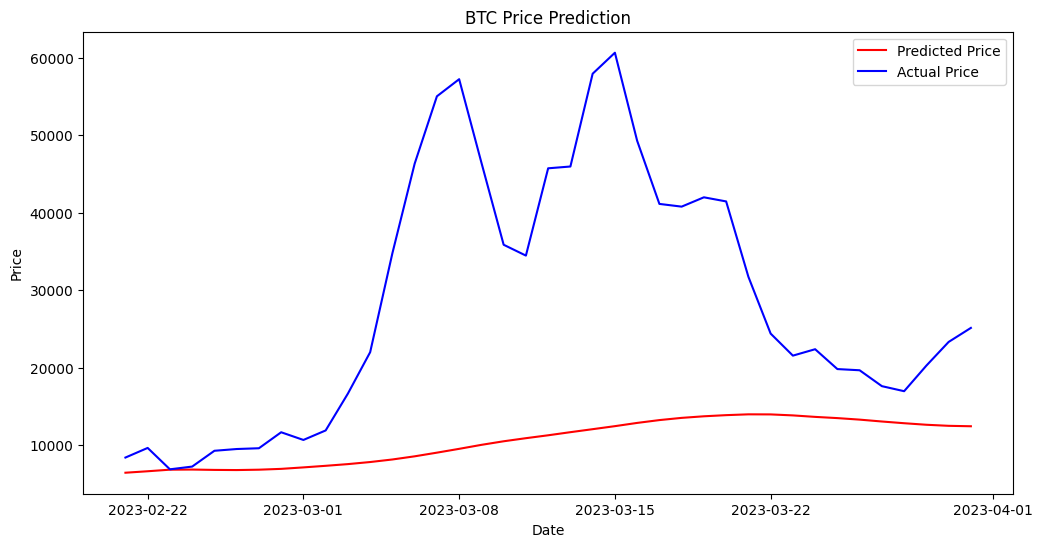

In [49]:
# Invert the scaling for predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_actual = scaler_btc.inverse_transform(y_pred)
y_test_actual = scaler_btc.inverse_transform(y_test)
# Evaluate the model
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R2 Score: {:.2f}".format(r2))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Price", color='r')
plt.plot(merged_df.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color='b')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.title("BTC Price Prediction")
plt.show()


1/1 [==============================] - 0s 78ms/step


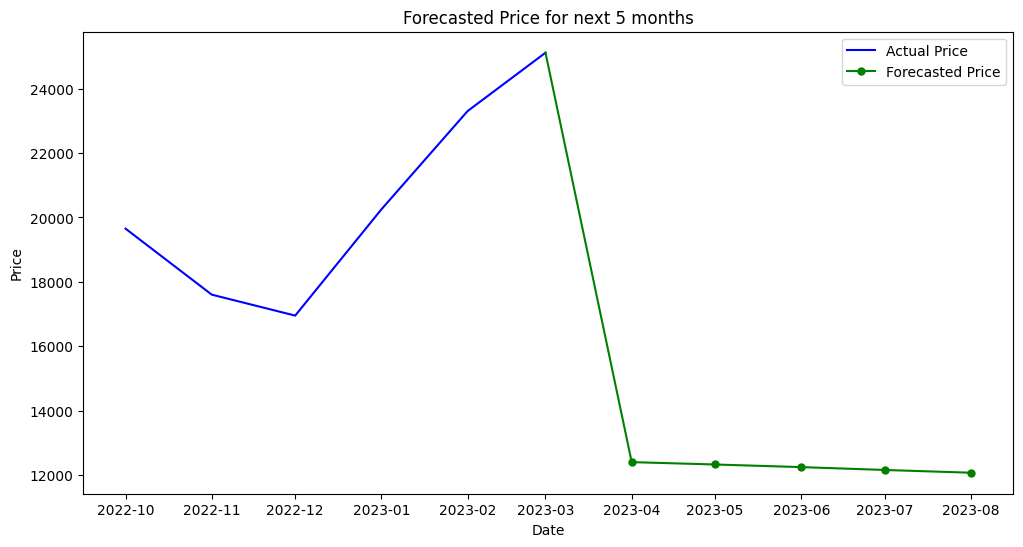

In [54]:
from pandas.tseries.offsets import DateOffset

# Create a function to convert month numbers back to dates
def month_num_to_date(month_num, start_date):
    return start_date + DateOffset(months=month_num)

start_date = pd.Timestamp("2014-01-01")

# Create dataframes for actual prices with dates as their index
actual_price_df = pd.DataFrame(scaler_btc.inverse_transform(monthly_avg[["Close"]]), 
                               index=monthly_avg.index.map(lambda x: month_num_to_date(x, start_date)), 
                               columns=["Actual Price"])

# Forecast for the next 5 months
x_forecast = monthly_avg[feature_columns].values[-n_past:]
forecasted_prices = []

for i in range(1, 6):  # i starts from 1 to 5
    x_forecast = x_forecast.reshape((1, n_past, len(feature_columns)))
    y_forecast = best_model.predict(x_forecast)
    forecasted_price_actual = scaler_btc.inverse_transform(y_forecast)
    forecasted_prices.append(forecasted_price_actual[0][0])
    next_month = monthly_avg.index[-1] + i
    new_row = np.array([y_forecast[0][0], x_forecast[0][-1][1]])
    x_forecast = np.append(x_forecast, new_row)
    x_forecast = x_forecast[-n_past * len(feature_columns):].reshape((n_past, len(feature_columns)))

# Add the forecasted prices to a new dataframe
forecasted_months = [month_num_to_date(month_num, start_date) for month_num in range(next_month-4, next_month+1)]
forecasted_price_df = pd.DataFrame(forecasted_prices, index=forecasted_months, columns=["Forecasted Price"])

# Limit the data to last 10 months
last_ten_months = forecasted_price_df.index[-1] - pd.DateOffset(months=10)
actual_price_df_last_ten_months = actual_price_df[last_ten_months:]
forecasted_price_df_last_ten_months = forecasted_price_df[forecasted_price_df.index > last_ten_months]

# Visualize the last 10 months of actual vs forecasted data
plt.figure(figsize=(12, 6))
plt.plot(actual_price_df_last_ten_months.index, actual_price_df_last_ten_months["Actual Price"], label="Actual Price", color='b')
plt.plot(forecasted_price_df_last_ten_months.index, forecasted_price_df_last_ten_months["Forecasted Price"], label="Forecasted Price", color='g', marker='o', markersize=5)

# Joining the forecasted line with the actual prices
if not actual_price_df_last_ten_months.empty:
    last_actual_price = actual_price_df_last_ten_months["Actual Price"].iloc[-1]
    first_forecasted_price = forecasted_price_df_last_ten_months["Forecasted Price"].iloc[0]
    plt.plot([actual_price_df_last_ten_months.index[-1], forecasted_price_df_last_ten_months.index[0]], [last_actual_price, first_forecasted_price], color='g')

plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc="best")
plt.title("Forecasted Price for next 5 months")
plt.show()
